# Authentication

In [1]:
from quantuminspire.qiskit import QI
from quantuminspire.credentials import enable_account
with open('token.txt', 'r') as f:
    enable_account(f.read())
QI.set_authentication(project_name='FractalDecomposition')

# Dependencies

In [2]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit.library import HamiltonianGate, RYGate, RZGate
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
import quantuminspire

from Hamiltonian import *

# Initial Conditions

In [45]:
N = 4 # Num qubits
theta = 0.195
phi = np.array([ [np.arccos(0.9) * np.abs(i-j)/(N-1) for j in range(N)] for i in range(N)])
delta = 1e-4
E = 1e-4
Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant']
V = np.sqrt(2)*4*Gf
Ne = 2
initial_flavors = np.array([0,0,1,1])

In [37]:
t_start = 0 
t_end = 10
steps = 50
shots = 1000

# Backend

## Noise Model (Simulation)

According to this tutorial https://qiskit.org/ecosystem/aer/tutorials/3_building_noise_models.html#Example-2:-T1/T2-thermal-relaxation, the units of T1, T2 seems to be in nanoseconds. Taking information about qubit 0,1,2,3, from Starmon-5 factsheet, we have the following thermal noise model.

In [38]:
T1s = np.array([17.4, 17.8, 17, 21.1]) * 1000 # nano to microseconds
T2s = np.array([28.2, 21.5, 26.6, 33.7]) * 1000
single_gate_time = 20 # single qubit gates complete in under 20 ns
double_gate_time = 60 # double qubits gates complete in under 60 ns
single_gates = ['rx','ry','rz','id']

In [39]:
noise = NoiseModel()
for i in range(N):
    for s in single_gates:
        error = thermal_relaxation_error(T1s[i], T2s[i], single_gate_time)
        noise.add_quantum_error(error, s, [i])
    
for i in range(N):
    for j in range(N):
        if i != j:
            error = thermal_relaxation_error(T1s[i], T2s[i], double_gate_time).expand(thermal_relaxation_error(T1s[j], T2s[j], double_gate_time))
            noise.add_quantum_error(error, 'cz', [i,j])

In [40]:
backend = AerSimulator(noise_model = noise) #QI.get_backend('Starmon-5') # TODO: Change to Starmon-5 when avaliable

# Dynamics

## Classical

In [41]:
classical_t_start = 0 
classical_t_end = 10
classical_steps = 500
H = Hamiltonian(N, theta, phi, delta, E, V, Ne)
classical_times = np.linspace(classical_t_start, classical_t_end, num=classical_steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(H, initial_state, classical_times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
classical_probabilities = np.zeros((N,classical_steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        classical_probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]

## Quantum

### One Body Hamiltonian

The one body Hamiltonian is a tensor product of single neutrino Hamiltonian, so it translates to single qubit gates applied in parallel. Thus it suffices to consider one such gate. The Hamiltonian for a single neutrino takes the form of $aX+bZ$. Diagonalizing this gives:
$$
\begin{bmatrix}
\frac{a{\sqrt{a^2+(c-b)^2}} & \frac{b-c}{\sqrt{a^2+(b-c)^2}}\\
\frac{c-b}{\sqrt{a^2+(c-b)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}}
\end{bmatrix}
\begin{bmatrix}
c & 0\\
0 & -c
\end{bmatrix}
\begin{bmatrix}
\frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{c-b}{\sqrt{a^2+(c-b)^2}} \\
\frac{b-c}{\sqrt{a^2+(b-c)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}}
\end{bmatrix}
$$

where $c=\sqrt{a^2+b^2}$.

The evolution operator $e^{-it(aX+bZ)}$ must be: 
$$
\begin{bmatrix}
\frac{a{\sqrt{a^2+(c-b)^2}} & \frac{b-c}{\sqrt{a^2+(b-c)^2}}\\
\frac{c-b}{\sqrt{a^2+(c-b)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}}
\end{bmatrix}
\begin{bmatrix}
e^{-itc} & 0\\
0 & e^{itc}
\end{bmatrix}
\begin{bmatrix}
\frac{a}{\sqrt{a^2+(c-b)^2}} & \frac{c-b}{\sqrt{a^2+(c-b)^2}} \\
\frac{b-c}{\sqrt{a^2+(b-c)^2}} & \frac{a}{\sqrt{a^2+(b-c)^2}}
\end{bmatrix}
$$


Now translating this into gates, given that 
$R_z(\phi) = e^{-i \frac{\phi}{2} Z}$ and $R_y(\theta) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\  \sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2}) \end{bmatrix}$, this means $e^{-it(aX+bZ)}=R_y(\theta)R_z(\phi)R_y(-\theta)$ where $\phi = 2tc$ and $\theta = 2\arctan(\frac{c-b}{a})$.

In [42]:
def OneBodyGate(t, theta, delta, E, V, Ne):
    Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant'] # TODO: check if the units are consistent
    msw = Gf * Ne/(np.sqrt(2) * V)
    omega = delta/(4 * E)
    a = omega * np.sin(2 * theta)
    b = msw - omega * np.cos(2 * theta)

    
    c = np.sqrt(a**2+b**2)
    Ry_angle = 2*np.arctan2(c-b,a)
    Rz_angle = 2*t*c
    return RYGate(-Ry_angle), RZGate(Rz_angle), RYGate(Ry_angle)

In [48]:
ts = np.linspace(t_start, t_end, num=steps)
# Create an array to store probabilities for each qubit at each time step
probabilities = np.zeros((N, steps))
stds = np.zeros((N, steps))
depths = []

for t_idx, t in enumerate(ts):
    circuit = QuantumCircuit(N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    
    for i in range(N):
        mRy, Rz, Ry = OneBodyGate(t/2,theta, delta, E, V, Ne)
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    for i in range(N):
        for j in range(i+1,N):
            H = TwoBodyHamiltonian(phi[i,j], V)
            H = HamiltonianGate(H.data.toarray(), t, label=f'TwoBodyHamiltonian {i},{j}')
            circuit.append(H, [i,j])

    for i in range(N):
        mRy, Rz, Ry = OneBodyGate(t/2,theta, delta, E, V, Ne)
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    circuit.measure_all()
        
    circ = transpile(circuit, backend)
    
    
    depths.append(circ.depth())
        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    # Iterate through the dictionary
    for bitstring, frequency in counts.items():
        # Convert the bitstring to a list of integers
        bit_list = list(map(int, bitstring)) # convert result from bitstring to list of integers
        bit_list = np.array(list(reversed(bit_list))) # reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    probabilities[:, t_idx] = probability

    std = np.sqrt((outcomes**2).mean(axis=0) - probability**2)
    assert len(std) == N
    stds[:, t_idx] = std

print(max(depths))

61


## Plots

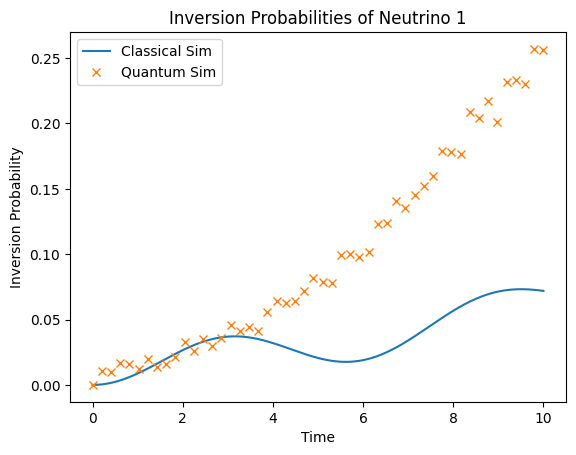

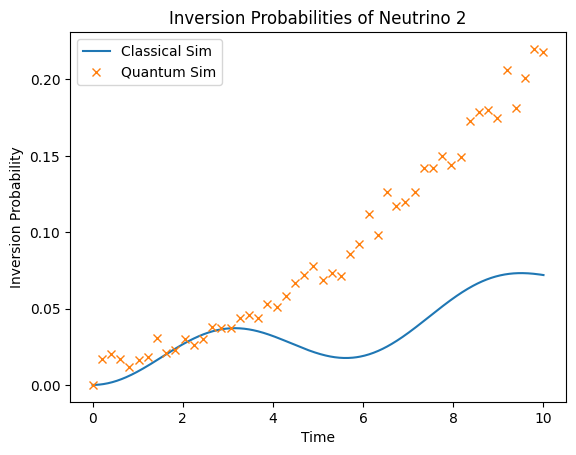

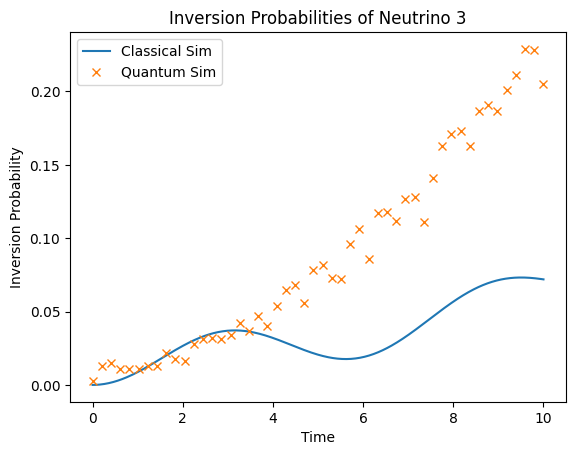

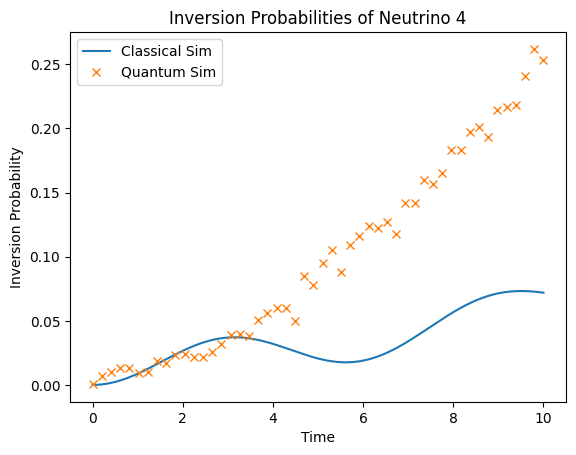

In [47]:
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.errorbar(classical_times, classical_probabilities[qubit], label=f'Classical Sim')
    plt.errorbar(ts, probabilities[qubit], label=f'Quantum Sim', linestyle='None', marker = 'x')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title(f'Inversion Probabilities of Neutrino {qubit+1}')
    plt.legend()
    plt.show()